In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 661M/675M [00:04<00:00, 153MB/s]
100% 675M/675M [00:04<00:00, 142MB/s]


Unzipping the folder

In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/cell-images-for-detecting-malaria.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

Importing Modules

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

Splitting the images in train and test directory

In [6]:
train_ds = datagen.flow_from_directory(
    directory = '/content/cell_images/cell_images',
    batch_size=16,
    class_mode = 'binary',
    subset='training',
    target_size=(128,128)
)

Found 22048 images belonging to 2 classes.


In [7]:
validation_ds = datagen.flow_from_directory(
    directory = '/content/cell_images/cell_images',
    batch_size=16,
    class_mode='binary',
    subset='validation',
    target_size=(128,128)
)

Found 5510 images belonging to 2 classes.


Custom CNN Model creation

In [8]:
from keras.layers import BatchNormalization,Dropout
from keras import layers
num_classes = 1

model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [13]:
history = model.fit_generator(generator = train_ds,
                             steps_per_epoch = len(train_ds),
                              epochs =20,
                              validation_data = validation_ds,
                              validation_steps=len(validation_ds),
                             callbacks=[early_stop])

<ipython-input-13-2de0d0f2be14>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_ds,


Epoch 1/20
1378/1378 [==============================] - 57s 32ms/step - loss: 0.4134 - accuracy: 0.8134 - val_loss: 0.1993 - val_accuracy: 0.9396
Epoch 2/20
1378/1378 [==============================] - 42s 30ms/step - loss: 0.1863 - accuracy: 0.9435 - val_loss: 0.1915 - val_accuracy: 0.9301
Epoch 3/20
1378/1378 [==============================] - 40s 29ms/step - loss: 0.1680 - accuracy: 0.9490 - val_loss: 0.1897 - val_accuracy: 0.9383
Epoch 4/20
1378/1378 [==============================] - 39s 29ms/step - loss: 0.1521 - accuracy: 0.9541 - val_loss: 0.1657 - val_accuracy: 0.9414
Epoch 5/20
1378/1378 [==============================] - 41s 30ms/step - loss: 0.1421 - accuracy: 0.9548 - val_loss: 0.1749 - val_accuracy: 0.9423
Epoch 6/20
1378/1378 [==============================] - 41s 30ms/step - loss: 0.1385 - accuracy: 0.9560 - val_loss: 0.1780 - val_accuracy: 0.9423


Plotting train_Accuracy Vs Val_accuracy graph
Plotting train_Loss and val_loss graph

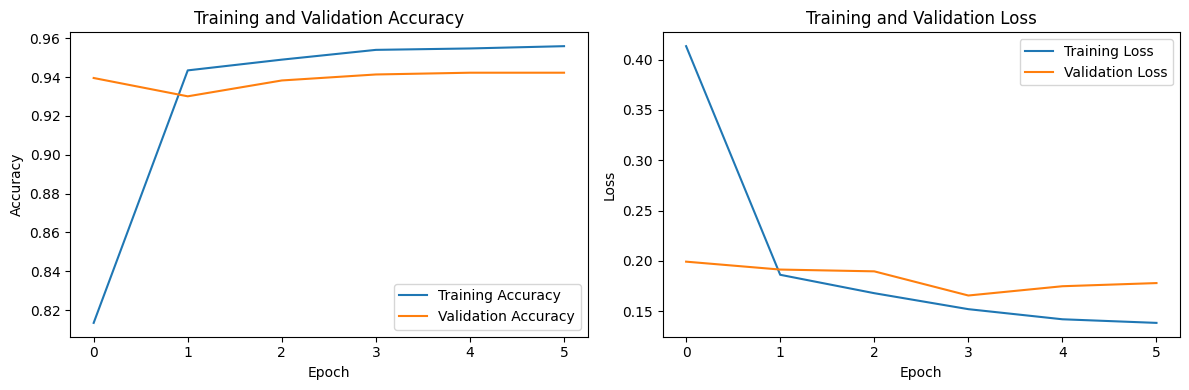

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plotting train vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting train vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Applying Transfer Learning : Using VGG16 Pretrained model with Data Augmentation

In [44]:
from keras.applications.vgg16 import VGG16

In [45]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(128,128,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [47]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [48]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [49]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [57]:
batch_size = 32

datagen1 = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True)


train_ds1 = datagen1.flow_from_directory(
        '/content/cell_images/cell_images',
        target_size=(150, 150),
        batch_size=batch_size,
        subset='training',
        class_mode='binary')

validation_ds1 = datagen1.flow_from_directory(
        '/content/cell_images/cell_images',
        target_size=(150, 150),
        batch_size=batch_size,
        subset='validation',
        class_mode='binary')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [58]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [59]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [60]:
history = model.fit_generator(generator = train_ds1,
                             steps_per_epoch = len(train_ds1),
                              epochs =20,
                              validation_data = validation_ds1,
                              validation_steps=len(validation_ds1),
                             callbacks=[early_stop])

<ipython-input-60-13e864cc961f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_ds1,


Epoch 1/20
689/689 [==============================] - 173s 247ms/step - loss: 0.1406 - accuracy: 0.9569 - val_loss: 0.1491 - val_accuracy: 0.9488
Epoch 2/20
689/689 [==============================] - 170s 247ms/step - loss: 0.1360 - accuracy: 0.9589 - val_loss: 0.1867 - val_accuracy: 0.9466
Epoch 3/20
689/689 [==============================] - 170s 247ms/step - loss: 0.1347 - accuracy: 0.9585 - val_loss: 0.1652 - val_accuracy: 0.9514


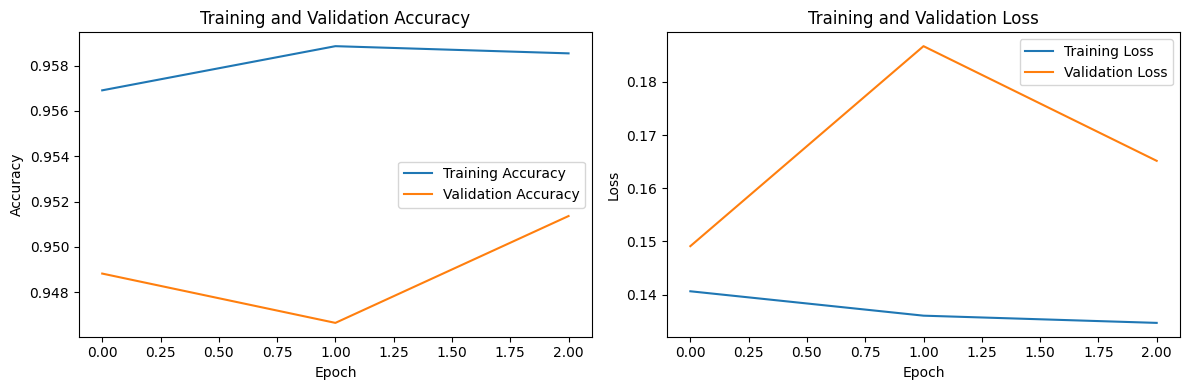

In [65]:
plt.figure(figsize=(12, 4))

# Plotting train vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting train vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()